These cells can be run in order to train the model.

Some comments in below cells refer to files in the Gagne github (https://github.com/djgagne/lorenz_gan). 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import time
from pickle import load
import tensorflow as tf
from tensorflow import keras
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")

tf.random.set_seed(42)
K = keras.backend

from sklearn.preprocessing import StandardScaler,PowerTransformer
import math
from scipy.stats import multivariate_normal
from scipy.stats import norm
import os
import pandas as pd
import pickle
from helper import *


import scipy.optimize


No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


Run the below cell if using a GPU.

In [ ]:
#using laptop gpu
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [8]:
k = 8
J = 32
save_time_step = 0.005
h=1 
c=10
b=10
F=20

# Prepare data #

In [9]:
train_dataset = np.load("../../data/truth_run/training_dataset.npy")
valid_dataset = np.load("../../data/truth_run/val_dataset.npy")

In [10]:
x_train = train_dataset[:,:,0]

In [11]:
u_t = -np.roll(x_train[:-1,:],1,axis=1) * (np.roll(x_train[:-1,:],2,axis=1) - np.roll(x_train[:-1,:],-1,axis=1)) - x_train[:-1,:] + F -(x_train[1:,:] - x_train[:-1,:])/save_time_step

In [13]:
x_t_ravel = np.ravel(x_train[:-1,:]).reshape(-1,1)
u_t_ravel = np.ravel(u_t).reshape(-1,1)

In [14]:
from sklearn.preprocessing import StandardScaler

In [15]:
scaler1 = StandardScaler()
scaler2 = StandardScaler()

In [16]:
x_t_scaled = scaler1.fit_transform(x_t_ravel)
u_t_scaled = scaler2.fit_transform(u_t_ravel)

# Model # 

## x-sml-r ##

In [17]:
"""
Generator.

Called "generator_dense_stoch" in the gagne github. The relevant files are:
train_loren_gan.py - def train_lorenz_gan
The config file used is lorenz_gan_travis.yaml
gan structure is "specified random" which from the "def train_lorenz_gan" means generator is the generator_dense_stoch 
and discriminator is discriminator_dense, both of which are specified in gan.py (the model layers are specified) as
separate functions
"""

codings_size = 1 + 1 + 2*16
noise_sd_training = 0.01

x_in = keras.layers.Input(shape=[1])
z_in = keras.layers.Input(shape=[codings_size])

z_in_input = z_in[:,:1]
z_in_add_input = z_in[:,1:2]
z_in_dense1 = z_in[:,2:2+16]
z_in_dense2 = z_in[:,-16:]

z_in_add_input_scaled = z_in_add_input*noise_sd_training
z_in_dense1_scaled = z_in_dense1*noise_sd_training
z_in_dense2_scaled = z_in_dense2*noise_sd_training

noisy_x = x_in + z_in_add_input_scaled
concat = keras.layers.Concatenate()([noisy_x,z_in_input])

layer1 = keras.layers.Dense(16,activation="selu",kernel_regularizer=keras.regularizers.l2(0.001))(concat)
layer1_noise = layer1 + z_in_dense1_scaled

layer2 = keras.layers.Dense(16,activation="selu",kernel_regularizer=keras.regularizers.l2(0.001))(layer1_noise)
layer2_noise = layer2 + z_in_dense2_scaled

final = keras.layers.Dense(1,kernel_regularizer=keras.regularizers.l2(0.001))(layer2_noise)
final_normalised = keras.layers.BatchNormalization()(final)

generator = keras.models.Model(inputs=[x_in,z_in],outputs=[final_normalised])  

In [18]:
"""
Discriminator.

Called "discriminator_dense" in Gagne github. See notes from generator above.
"""

u_in = keras.layers.Input(shape=[1])
x_in = keras.layers.Input(shape=[1])
concat = keras.layers.Concatenate()([x_in,u_in])
add_noise_1 = keras.layers.GaussianNoise(noise_sd_training)(concat) #these noise layers are only used in training
layer1 = keras.layers.Dense(16,activation="selu",kernel_regularizer=keras.regularizers.l2(0.001))(add_noise_1)
add_noise_2 = keras.layers.GaussianNoise(noise_sd_training)(layer1)
layer2 = keras.layers.Dense(16,activation="selu",kernel_regularizer=keras.regularizers.l2(0.001))(add_noise_2)
final = keras.layers.Dense(1,activation="sigmoid",kernel_regularizer=keras.regularizers.l2(0.001))(layer2)

discriminator = keras.models.Model(inputs=[x_in,u_in],outputs=[final])


In [19]:
#important to include this epsilon to prevent overflow and nans.
def discriminator_loss(real_data,fake_data):
    epsilon = 1e-7
    epsilon_ = tf.constant(epsilon)
    real_data_pred = tf.clip_by_value(discriminator(real_data),epsilon_,1. - epsilon_)
    term1 = 0.5*(K.log(real_data_pred + epsilon_))
    fake_data_pred = tf.clip_by_value(discriminator(fake_data),epsilon_,1. - epsilon_)
    term2 = 0.5*(K.log(1.-fake_data_pred+ epsilon_))
    loglik = term1+term2
    loss = -tf.reduce_mean(loglik)
    return loss

#non saturating 
def generator_loss(fake_data):
    epsilon = 1e-7
    epsilon_ = tf.constant(epsilon)   
    fake_data_pred = tf.clip_by_value(discriminator(fake_data),epsilon_,1. - epsilon_)
    term = 0.5*(K.log(fake_data_pred + epsilon_))
    loss = -tf.reduce_mean(term)
    return loss

In [20]:
d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001)
g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

@tf.function
def disc_step(real_data,fake_data):
    """Decorated train_step function which applies a gradient update to the parameters"""
    with tf.GradientTape() as tape:
        loss = discriminator_loss(real_data,fake_data)
        loss = tf.add_n([loss] + discriminator.losses)
    gradients = tape.gradient(loss, discriminator.trainable_variables)
    d_optimizer.apply_gradients(zip(gradients, discriminator.trainable_variables))
    return loss

@tf.function 
def gen_step(noise,real_data_x):
    """Decorated train_step function which applies a gradient update to the parameters"""
    with tf.GradientTape() as tape:
        fake_u = generator([real_data_x,noise])
        fake_data = [real_data_x,fake_u]
        loss = generator_loss(fake_data)
        loss = tf.add_n([loss] + generator.losses)
    gradients = tape.gradient(loss, generator.trainable_variables)
    g_optimizer.apply_gradients(zip(gradients, generator.trainable_variables))
    return loss

In [21]:
def create_batch(input_list, batch_s=32):
    
    batch_list = []
    shape_label = input_list[0].shape[0]
    batch_idx_la = np.random.choice(list(range(shape_label)), batch_s)
    for i in input_list: 
        batch_item = (i[batch_idx_la,])
        batch_list.append(batch_item)
    
    del batch_idx_la
            
    return batch_list

def list_average(list_of_loss):
    return sum(list_of_loss)/len(list_of_loss)

In [22]:
input_dataset = [x_t_scaled,u_t_scaled]

In [34]:
def fit_model(input_list,epochs,
              batch_size=1024):
    
    K.clear_session()    
    batches_per_epoch = int(np.floor(input_list[0].shape[0]/batch_size))
    gen_batch_loss = []
    gen_history_full = []   
    half_batch = int(batch_size/2)
    for epoch in range(epochs):
            print("Epoch {}/{}".format(epoch+1,epochs))

            for i in range(batches_per_epoch):

                batch_list= create_batch(
                    input_list,batch_size)
                x_real = batch_list[0][:half_batch]
                u_real = batch_list[1][:half_batch]
                real_data = [x_real,u_real]                    
                random_noise = tf.random.normal(shape=(half_batch,codings_size))
                x_real_2 = batch_list[0][half_batch:]
                u_fake = generator([x_real_2,random_noise])
                fake_data = [x_real_2,u_fake]
                loss = disc_step(real_data,fake_data)

                batch_list= create_batch(
                    input_list,batch_size)
                random_noise = tf.random.normal(shape=(batch_size,codings_size))
                x_real = batch_list[0]
                loss = gen_step(random_noise,x_real)
                gen_batch_loss.append(loss)
                gen_average_batch_loss = list_average(gen_batch_loss)

            gen_batch_loss = []
            gen_history_full.append(gen_average_batch_loss)

            generator.save("test_generator.h5")
            discriminator.save("test_discriminator.h5")

    plt.plot(gen_history_full,label="gen_training_loss",color='g')


# Training #

Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


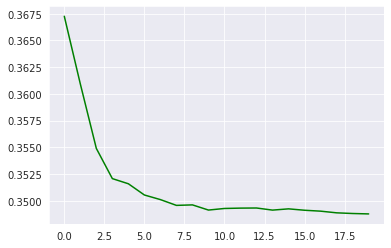

In [21]:
fit_model(input_dataset,20,batch_size=1024)

In [22]:
# generator.save("gan_generator_updatedv2.h5")
# discriminator.save("gan_discriminator_updatedv2.h5")


Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


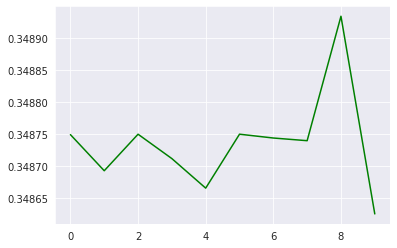

In [23]:
fit_model(input_dataset,10,batch_size=1024)

In [24]:
# save final models #

# generator.save("gan_generator_final.h5")
# discriminator.save("gan_discriminator_final.h5")


## AR1 parameters ##

In [53]:
generator = keras.models.load_model("gan_generator_final.h5")

In [54]:
input_dataset3 = [x_t_scaled,np.random.normal(size=(x_t_scaled.shape[0],codings_size))]

In [55]:
u_t_pred = generator(input_dataset3)

In [56]:
u_t_pred_unscaled_gagne_gan = scaler2.inverse_transform(u_t_pred)

In [57]:
residual = u_t - u_t_pred_unscaled_gagne_gan.reshape(-1,k)

In [58]:
residual_shaped = residual.reshape(-1,order="f")


In [59]:
phi = np.corrcoef(residual_shaped[:-1],residual_shaped[1:])[1,0]
phi

0.7482097450854712

In [60]:
sigma = (1-phi**2)**0.5
sigma

0.6634622652111679